In [124]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score ,accuracy_score , roc_curve
from statsmodels.formula.api import logit
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

%matplotlib inline

In [125]:
data = pd.read_csv("bankloans.csv")

In [126]:
data.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


In [127]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       850 non-null    int64  
 1   ed        850 non-null    int64  
 2   employ    850 non-null    int64  
 3   address   850 non-null    int64  
 4   income    850 non-null    int64  
 5   debtinc   850 non-null    float64
 6   creddebt  850 non-null    float64
 7   othdebt   850 non-null    float64
 8   default   700 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 59.9 KB


In [128]:
continous_variables = data.select_dtypes(["int64", "float64"])
catagorical_variables = data.select_dtypes("object")

In [129]:
def con_summary(x):
    return pd.Series([x.shape[0], x.shape[0] - x.count(),
                      x.mean() ,
                      x.quantile(0) , x.quantile(0.01) , x.quantile(0.05), x.quantile(0.1),
                      x.quantile(0.25), x.quantile(0.5), x.quantile(0.75) , 
                      x.quantile(0.9) , x.quantile(0.95) , x.quantile(0.99), x.quantile(1)] ,
                    index = ["No of Observation" , "No of missing" , 
                             "Mean" ,
                             "Min" , "0.01" , "0.05" , "0.10" ,
                             "0.25" , "0.5" , "0.75" ,
                              "0.90" , "0.95" , "0.99" , "Max" ])

## Data Audit

In [130]:
continous_variables.apply(con_summary).T

,No of Observation,No of missing,Mean,Min,0.01,0.05,0.10,0.25,0.5,0.75,0.90,0.95,0.99,Max
age,850.0,0.0,35.029412,20.000000,21.000000,23.000000,25.000000,29.000000,34.000000,41.000000,47.000000,49.000000,53.000000,56.00000
ed,850.0,0.0,1.710588,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,3.000000,4.000000,4.000000,5.00000
employ,850.0,0.0,8.565882,0.000000,0.000000,0.000000,1.000000,3.000000,7.000000,13.000000,18.000000,21.550000,29.000000,33.00000
address,850.0,0.0,8.371765,0.000000,0.000000,0.000000,1.000000,3.000000,7.000000,12.000000,19.000000,22.550000,26.510000,34.00000
income,850.0,0.0,46.675294,13.000000,14.490000,17.000000,19.000000,24.000000,35.000000,55.750000,84.000000,115.550000,220.510000,446.00000
debtinc,850.0,0.0,10.171647,0.100000,0.900000,1.900000,2.900000,5.100000,8.700000,13.800000,19.200000,23.510000,31.565000,41.30000
creddebt,850.0,0.0,1.576805,0.011696,0.030349,0.108927,0.178306,0.382176,0.885091,1.898440,3.703304,5.348674,10.285997,20.56131
othdebt,850.0,0.0,3.078789,0.045584,0.162394,0.359900,0.552050,1.045942,2.003243,3.903001,7.111941,9.481105,16.931503,35.19750
default,850.0,150.0,0.261429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.00000


## Data Analysis

#### Outlier Treatment on < 0.01 and > 0.99 quantiles 

In [131]:
continous_variables = continous_variables.apply(lambda x: x.clip(lower = x.quantile(0.01) , upper = x.quantile(0.99)))

In [132]:
def miss_imp(x):
    if x.name != "default":
        return x.fillna(x.mean())

#### Missing Value imputation

In [133]:
continous_variables = continous_variables.apply( miss_imp )

In [134]:
continous_variables.ed = round(continous_variables.ed)

In [135]:
continous_variables["default"] = data.default

#### Seprating old customer from new ones

In [136]:
data_new = continous_variables[700:]
data_old = continous_variables[:700]

#### Checking assumption of Logistic Regression and finding Information Value

In [137]:
def IV_WOE(df , target , bins = 10 ):
    iv , woe  =pd.DataFrame() , pd.DataFrame()
    
    cols = df.columns
    
    for feature in cols[~cols.isin([target])]:
        if len(np.unique(df[feature])) > 2:
            binned_X = pd.qcut(df[feature], bins , duplicates = "drop")
            binned_n_target = pd.DataFrame({"x" : binned_X, "y": df[target]})
        else:
            binned_n_target = pd.DataFrame({"x" : df[feature] , "y" : df[target]})
        woe_if = binned_n_target.groupby("x")["y"].agg(["count" ,"sum"]).reset_index()
        woe_if.columns = ["CUT_OFF", "N" , "Event"]
        woe_if["% Event"] = woe_if.Event / woe_if.Event.sum()
        woe_if["Non Event"] = woe_if.N - woe_if.Event
        woe_if["% Non Event"] = woe_if["Non Event"] / woe_if["Non Event"].sum()
        woe_if['WOE'] = np.log(woe_if['% Event'] / woe_if['% Non Event'])
        woe_if['IV'] = woe_if['WOE'] * (woe_if['% Event'] - woe_if['% Non Event'])
        woe_if.insert(0,"Feature", feature)
        woe = pd.concat([woe , woe_if])
        print(f"Information Value of {feature} is {np.sum(woe_if.IV)}")
    iv = woe.groupby("Feature")["IV"].sum().reset_index().sort_values("IV")
    return woe ,iv

## Assumption 

- Linearity in Log Odds of a variable
- No Multi Colinearity
- No Heteroscedasticity
- No Auto Correlation 

#### Weight Of Evidence (WOE) of the continous variable should be Linear (Logistic Regression Assumption)

##### Information Value indicates about the sepration betweeen the happening of event (defaulter) and not happening of event (not a defaulter)

##### Or the value of information provided by the feature

In [138]:
woe, iv = IV_WOE(data_old , "default")

Information Value of age is 0.24400037606590727
Information Value of ed is 0.0411824153402818
Information Value of employ is 0.622351238222967
Information Value of address is 0.2371926430838918
Information Value of income is 0.18451274541583207
Information Value of debtinc is 0.7757827299557415
Information Value of creddebt is 0.3233493955785788
Information Value of othdebt is 0.15510306942591767


#### Variable "debtinc" validates the assumption

##### WOE ( Log Odds ) is Linear

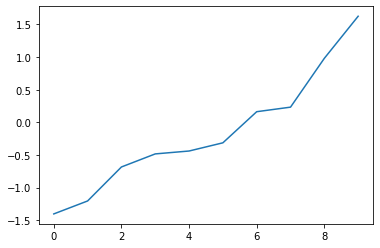

In [139]:
woe[woe.Feature == "debtinc"].WOE.plot()
plt.show()

#### Variable "income" does not validates the assumption

##### WOE ( Log Odds ) is not Linear

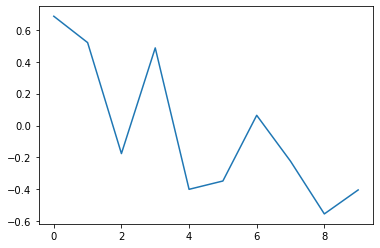

In [140]:
woe[woe.Feature == "income"].WOE.plot()
plt.show()

#### Checking assumption. No Multi Collinearity (i.e. feature are correlated with each other) in the features. 

##### Variance Inflation Factor is used to check the assumption.

In [141]:
vif = pd.DataFrame()
vif["Features"] = data_old.columns.difference(["default"])
vif["vif"] = [variance_inflation_factor(data_old.iloc[: , :-1].values , i) for i in range(vif.Features.shape[0])]

In [142]:
vif = vif.sort_values("vif")

#### Variation Inflation Factor of some variable are above the cut off

##### There is Multi Collinearity. This will make our Linear Model unstable.

In [143]:
vif

,Features,vif
3,debtinc,3.587253
6,income,4.250900
1,age,5.135571
2,creddebt,6.108172
7,othdebt,7.886603
5,employ,10.439409
4,ed,13.666786
0,address,18.200828


#### Spliting the data into Train and Test

In [144]:
train ,test = train_test_split(data_old, test_size = 0.3 ,random_state =42)

#### Generating a formula for our model with all of our independent features

In [145]:
model_formula = "default ~ " + " + ".join(train[train.columns.difference(["default"])])

In [146]:
model_formula

'default ~ address + age + creddebt + debtinc + ed + employ + income + othdebt'

In [147]:
all_models = pd.DataFrame()

In [148]:
train

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
357,24,2,0,2.0,15.0,16.1,0.321195,2.093805,1.0
649,29,2,5,7.0,28.0,18.7,2.125816,3.110184,0.0
291,33,4,9,8.0,32.0,5.5,0.496320,1.263680,0.0
420,46,1,1,15.0,21.0,14.8,1.376844,1.731156,1.0
177,28,2,7,2.0,34.0,7.0,0.359380,2.020620,0.0
...,...,...,...,...,...,...,...,...,...
71,28,2,5,9.0,34.0,23.8,3.099236,4.992764,0.0
106,53,1,9,18.0,50.0,11.2,2.016000,3.584000,1.0
270,51,2,22,23.0,120.0,7.6,4.140480,4.979520,0.0
435,24,2,1,2.0,42.0,5.7,0.837900,1.556100,0.0


#### Creating a Logistic Model on all of our features for further analysis.

In [149]:
LM1 = logit(model_formula , train).fit()

Optimization terminated successfully.
         Current function value: 0.425337
         Iterations 7


##### Many variable are in significant according to the P value. (Confidence Interval :- 0.95) 

In [150]:
print(LM1.summary())

                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                  490
Model:                          Logit   Df Residuals:                      481
Method:                           MLE   Df Model:                            8
Date:                Sun, 08 Nov 2020   Pseudo R-squ.:                  0.2750
Time:                        14:31:53   Log-Likelihood:                -208.42
converged:                       True   LL-Null:                       -287.47
Covariance Type:            nonrobust   LLR p-value:                 3.962e-30
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4125      0.738     -1.913      0.056      -2.860       0.035
address       -0.0855      0.026     -3.314      0.001      -0.136      -0.035
age            0.0385      0.020      1.908      0.0

#### For Feature Selection Somers'D is used. 

##### Somers'D is the information that a particular variable adds, other words it indicates how better it is than a random classifier if only this variable is used for modelling.

In [151]:
somers_d = pd.DataFrame()
for feature in train.columns.difference(["default"]):
    model = logit( "default ~ " + str(feature), train).fit()
    somersd = 2 * roc_auc_score(train.default , model.predict()) -1
    temp = pd.DataFrame([feature, somersd]).T
    temp.columns = ["Feature Name", "Somers'D"]
    somers_d = pd.concat([somers_d , temp] , axis= 0 )
somers_d.sort_values("Somers'D" ,ascending= False)

Optimization terminated successfully.
         Current function value: 0.575906
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.524565
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.580706
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536440
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.582459
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577694
         Iterations 5


,Feature Name,Somers'D
0,debtinc,0.429146
0,employ,0.415395
0,creddebt,0.22757
0,income,0.224489
0,address,0.19751
0,age,0.169001
0,othdebt,0.144579
0,ed,0.14177


##### Now with the help of Somers'D metric a Feature Selection can be done

#### Heat Map of Correlation Matrix of the data also indicates Multi Collinearity

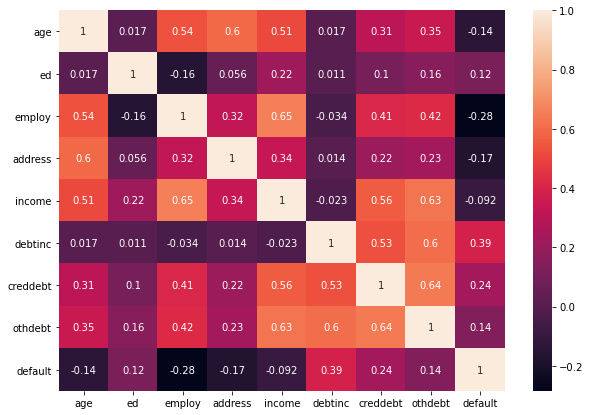

In [152]:
plt.figure(figsize=(10,7))
sns.heatmap(data_old.corr(), annot= True)
plt.show()

#### Droping variable with the help of Somers'D, Variation Inflation Factor and Model Summary.

In [153]:
train_reduced = train.drop(["othdebt", "income", "ed"], axis= 1 )

In [154]:
model_formula = "default ~ " + " + ".join(train_reduced.columns.difference(["default"]))
y, X  = dmatrices(model_formula , train_reduced, return_type= "dataframe")

#### Checking Variation Inflation Factor for any Multi Collinearity in the data now

In [155]:
vif_table = pd.DataFrame()
vif_table["Features"] = X.columns
vif_table["VIF"] = [variance_inflation_factor( X.values , i) for i in range(X.shape[1])]

In [156]:
vif_table

,Features,VIF
0,Intercept,27.202939
1,address,1.578602
2,age,2.038613
3,creddebt,1.811997
4,debtinc,1.507148
5,employ,1.699867


#### Multi Collinearity Assumption Satisfied

#### Now again checking the Feature Importance by the help of Somers'D

In [157]:
somers_d = pd.DataFrame()
for feature in train_reduced.columns.difference(["default"]):
    model = logit( "default ~ " + str(feature), train).fit()
    somersd = 2 * roc_auc_score(train.default , model.predict()) -1
    temp = pd.DataFrame([feature, somersd]).T
    temp.columns = ["Feature Name", "Somers'D"]
    somers_d = pd.concat([somers_d , temp] , axis= 0 )
somers_d.sort_values("Somers'D" ,ascending= False)

Optimization terminated successfully.
         Current function value: 0.575906
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.524565
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.536440
         Iterations 6


,Feature Name,Somers'D
0,debtinc,0.429146
0,employ,0.415395
0,creddebt,0.22757
0,address,0.19751
0,age,0.169001


## Building a Logistic Model

In [158]:
model_formula = "default ~ " + " + ".join(train_reduced.columns.difference(["default"]))
my_model = logit(model_formula , train_reduced).fit()
print(my_model.summary())

Optimization terminated successfully.
         Current function value: 0.426723
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                  490
Model:                          Logit   Df Residuals:                      484
Method:                           MLE   Df Model:                            5
Date:                Sun, 08 Nov 2020   Pseudo R-squ.:                  0.2726
Time:                        14:31:57   Log-Likelihood:                -209.09
converged:                       True   LL-Null:                       -287.47
Covariance Type:            nonrobust   LLR p-value:                 4.859e-32
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.7589      0.584     -3.014      0.003      -2.903      -0.615
address       -0.0841      0.

##### All the variable are significant based upon the P value. (Confidance Interval:- 0.95)

## Validating the Model

In [159]:
train_p = pd.DataFrame()
train_p["prediction_percentage"] = my_model.predict( train_reduced.iloc[:,:-1] )
train_p["true_values"] = train_reduced.default

#### Confusion Matrix 

##### On 0.5 Cut off i.e. probability > 0.5 ( predict label 1 ) and probability < 0.5 ( predict label 0 )

D:\Data_Science\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass labels=[1, 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Text(0.5, 15.0, 'Predicted Label')

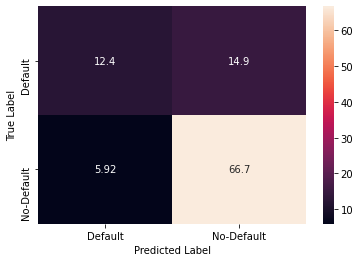

In [160]:
sns.heatmap((confusion_matrix(train_p.true_values ,train_p.prediction_percentage > 0.50, [1,0]) / train_p.shape[0]) * 100,
            fmt= "0.3g" ,annot= True, xticklabels=["Default", "No-Default"] ,yticklabels=["Default" ,"No-Default" ])
plt.ylabel("True Label")
plt.xlabel("Predicted Label")

#### Need to find best cut off with the help of different metric 

- Senstivity / Recall 
- Specificity
- Precision

In [161]:
roc_cut_off_df = pd.DataFrame()
for cut_off in np.linspace(0 ,1 ,100):
    train_p["predicted_values"] = (train_p.prediction_percentage > cut_off).astype("float")
    train_p["tp"] = confusion_matrix(train_p.true_values ,train_p.prediction_percentage > cut_off, [1,0])[0 ,0]
    train_p["tn"] = confusion_matrix(train_p.true_values ,train_p.prediction_percentage > cut_off, [1,0])[1 ,1]
    train_p["fp"] = confusion_matrix(train_p.true_values ,train_p.prediction_percentage > cut_off, [1,0])[1 ,0]
    train_p["fn"] = confusion_matrix(train_p.true_values ,train_p.prediction_percentage > cut_off, [1,0])[0 ,1]
    senstivity = train_p.tp.sum() / (train_p.tp.sum() + train_p.fn.sum())

    specificity = train_p.tn.sum() / (train_p .tn.sum() + train_p.fp.sum())
    accuracy = (train_p.tp.sum() + train_p.tn.sum()) / ( train_p.tp.sum() + train_p.tn.sum() + train_p.fp.sum() + train_p.fn.sum())

    
    roc_cut_off_obs = pd.DataFrame([cut_off , senstivity, specificity , accuracy]).T
    roc_cut_off_obs.columns = ["Cut Off", "senstivity" ,"specificity", "accuracy"]
    
    roc_cut_off_df = pd.concat([roc_cut_off_df , roc_cut_off_obs])

#### Now a cut off is needed that provides high True Positive Rate ( Recall ) and Low False Negative Rate ( 1 - Specificity )

##### Recall ( High ) and 1 - Specificity ( Low ) ->  Recall ( High ) and Specificity ( High )

##### So we want to maximize ( Senstivity + Specificity )

In [162]:
roc_cut_off_df["Sens+Spec"] = roc_cut_off_df.senstivity + roc_cut_off_df.specificity

In [163]:
roc_cut_off_df

,Cut Off,senstivity,specificity,accuracy,Sens+Spec
0,0.000000,1.000000,0.000000,0.273469,1.000000
0,0.010101,1.000000,0.106742,0.351020,1.106742
0,0.020202,1.000000,0.168539,0.395918,1.168539
0,0.030303,0.992537,0.227528,0.436735,1.220065
0,0.040404,0.985075,0.266854,0.463265,1.251929
...,...,...,...,...,...
0,0.959596,0.022388,1.000000,0.732653,1.022388
0,0.969697,0.014925,1.000000,0.730612,1.014925
0,0.979798,0.007463,1.000000,0.728571,1.007463
0,0.989899,0.000000,1.000000,0.726531,1.000000


In [164]:
best_accuracy = roc_cut_off_df[roc_cut_off_df["Sens+Spec"] == roc_cut_off_df["Sens+Spec"].max()]

In [165]:
best_accuracy

,Cut Off,senstivity,specificity,accuracy,Sens+Spec
0,0.343434,0.738806,0.789326,0.77551,1.528132


In [166]:
best_accuracy["Cut Off"].to_list()[0]

0.3434343434343435

#### Area under the ROC Curve is used to validate the model.

In [167]:
roc_auc_score(train_p.true_values ,train_p.prediction_percentage)

0.8379800436022138

#### Representation of ROC curve and the cut off having maximum ( Senstivity + Specificity )

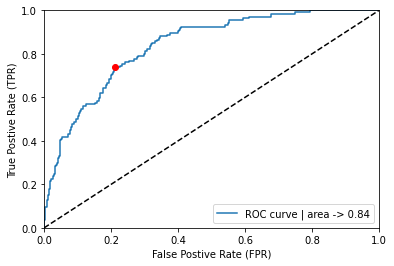

In [172]:
fpr , tpr , cut_off= roc_curve(train_p.true_values , train_p.prediction_percentage)
plt.plot(fpr ,tpr ,label = f"ROC curve | area -> {round(roc_auc_score(train_p.true_values ,train_p.prediction_percentage), 2)}")
plt.plot(1 - best_accuracy.specificity ,best_accuracy.senstivity,'ro') 
plt.plot([0 , 1], [0 , 1], "k--")
plt.xlabel("False Postive Rate (FPR)")
plt.ylabel("True Postive Rate (TPR)")
plt.xlim([0.0 ,1.0])
plt.ylim([0.0 ,1.0])
plt.legend(loc = 4)
plt.show()

In [169]:
test_predict = my_model.predict(test.iloc[: , :-1])

In [110]:
accuracy_score(test.default , test_predict > 0.3434)

0.819047619047619

In [115]:
test_p = test_predict

In [116]:
test_p = pd.concat([test.default, test_p], axis= 1)

In [117]:
test_p.columns= ["true_value", "prediction_percentage"]

D:\Data_Science\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass labels=[1, 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


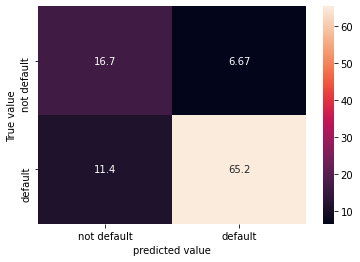

In [121]:
sns.heatmap((confusion_matrix(test_p.true_value ,test_p.prediction_percentage > best_accuracy["Cut Off"].to_list()[0] , [1,0]) / test_p.shape[0]) * 100 ,
           annot= True, fmt= "0.3g", xticklabels=["not default", "default"], yticklabels=["not default", "default"])
plt.ylabel("True value")
plt.xlabel("predicted value")
plt.show()

In [122]:
data_new.loc[:, "default"] = (my_model.predict(data_new.iloc[:, :-1]) > 0.3434).astype(int)

D:\Data_Science\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [123]:
data_new

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
700,36,1,16,13.00,32.0,10.9,0.544128,2.943872,0
701,50,1,6,26.51,21.0,12.9,1.316574,1.392426,0
702,40,1,9,9.00,33.0,17.0,4.880700,0.729300,1
703,31,1,5,7.00,23.0,2.0,0.046000,0.414000,0
704,29,1,4,0.00,24.0,7.8,0.866736,1.005264,1
...,...,...,...,...,...,...,...,...,...
845,34,1,12,15.00,32.0,2.7,0.239328,0.624672,0
846,32,2,12,11.00,116.0,5.7,4.026708,2.585292,0
847,48,1,13,11.00,38.0,10.8,0.722304,3.381696,0
848,35,2,1,11.00,24.0,7.8,0.417456,1.454544,0
